<h1> Mulivariate Discriminant </h1>

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.dates as md
import scipy.io as sio
from scipy.optimize import curve_fit # for fitting
import scipy.stats
from numpy import random, histogram2d, diff
import matplotlib as mpl #next two lines are to deal with X-code issues in server
mpl.use('Agg')
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 22})

Populating the interactive namespace from numpy and matplotlib


In [2]:
mat_data=sio.loadmat('../data/Platinum/Platinum_Run03_WS.mat')
ch3t_data=sio.loadmat('../data/Platinum/Platinum_CH3T_Aug.mat')
dd_data=sio.loadmat('../data/Platinum/Platinum_DD_Run03.mat')

In [3]:
def create_df(mat_data):
	g1=0.117
	g2=12.05
	
	df=df_from_mat(mat_data)
	# convert luxstamp to date_num
	lux_epoch=md.datestr2num('Jan 1st 2011 at 00:00')
	luxstamp2day=df['luxstamp']/10**8/3600/24
	luxdatenum=md.num2date(luxstamp2day+lux_epoch)
	df['luxdatenum']=luxdatenum
	df['log10S2spikyS1']=np.log10(df['s2area']/df['spikyS1'])
	#df['rawlog10S2spikyS1']=log10(df['s2area_raw']/df['spikyS1_raw'])
	df['log10S2S1']=np.log10(df['s2area']/df['s1area'])
	df['log10S2S1_raw']=np.log10(df['s2area_raw']/df['s1area_raw'])
	df['s2radius_corr']=np.sqrt(df['corrected_x']**2 + df['corrected_y']**2)
	df['s2radius2_corr']=df['corrected_x']**2 + df['corrected_y']**2
	df['energy']=1/73*(df['spikyS1']/g1 + df['s2area']/g2)
	df['x']=df['s1area']
	df['y']=df['log10S2S1']
	if (max(df.index)>3000):
		df_cut=np.int32(np.random.uniform(0,max(df.index),3000))
		df=df.iloc[df_cut]
	return df


def df_from_mat(mat_data):
    a=[]
    keys=[]
    
    for key in mat_data.keys():
        if key[0]!='_':
            a.append(mat_data[key])
            keys.append(key)
    keys=np.array(keys)
    return pd.DataFrame(np.vstack(a[:]).T,columns=keys)

#input x,y range in the future for selected region 
def pdf_gen(x_var,y_var,x_range_sel,y_range_sel,nbins = 100):
    x_var=np.array(x_var) #first convert to np array for logical cuts
    y_var=np.array(y_var)
    cut= (x_var>=x_range_sel[0]) & (x_var<=x_range_sel[1]) & (y_var>=y_range_sel[0]) & (y_var<=y_range_sel[1])
    x_var=x_var[cut]
    y_var=y_var[cut]
    H, xedges, yedges = histogram2d(x_var,y_var, bins=nbins,normed=1)
    H=H.T
    xcenters = xedges[:-1] + diff(xedges[:2])/2
    ycenters = yedges[:-1] + diff(yedges[:2])/2
    #Construct interpolator
    pdf = interp2d(xcenters, ycenters, H, kind='linear')
    x_r=[xedges.min(),xedges.max()]
    y_r=[yedges.min(),yedges.max()]
    
    x_range=linspace(0,50,nbins)
    y_range=linspace(1,4,nbins)
    # fit a KDE to the data
    pdf=scipy.stats.kde.gaussian_kde([x_var,y_var])
    q,w=np.meshgrid(x_range, y_range)
    r1=pdf([q.flatten(),w.flatten()])
    r1.shape=(size(y_range),size(x_range))
    r1=r1/sum(r1) #normalize the pdf
    return r1, x_var, y_var, x_range, y_range


In [4]:
df_all=create_df(mat_data)
df_ch3t=create_df(ch3t_data)
df_dd=create_df(dd_data)

<h1> Calculate the PDFs </h1>

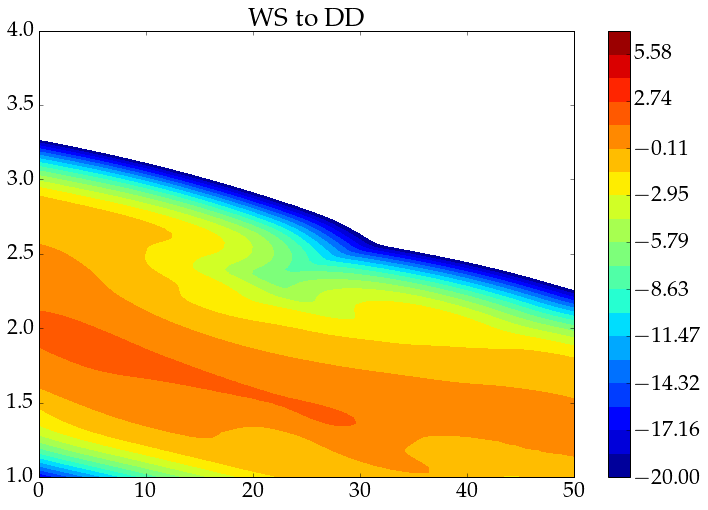

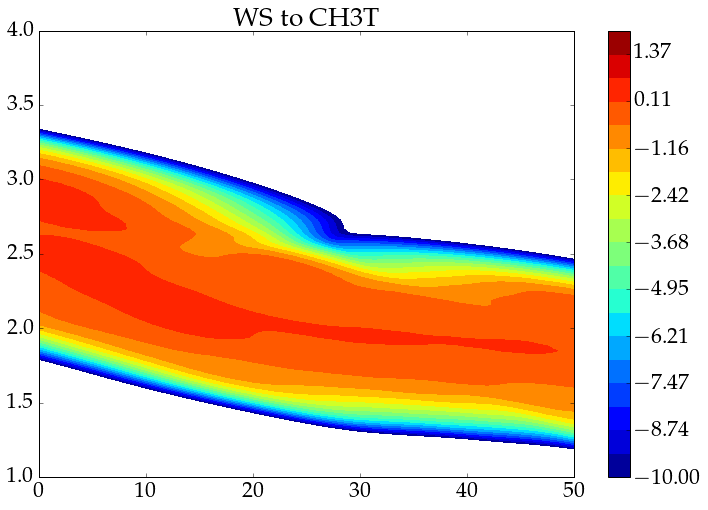

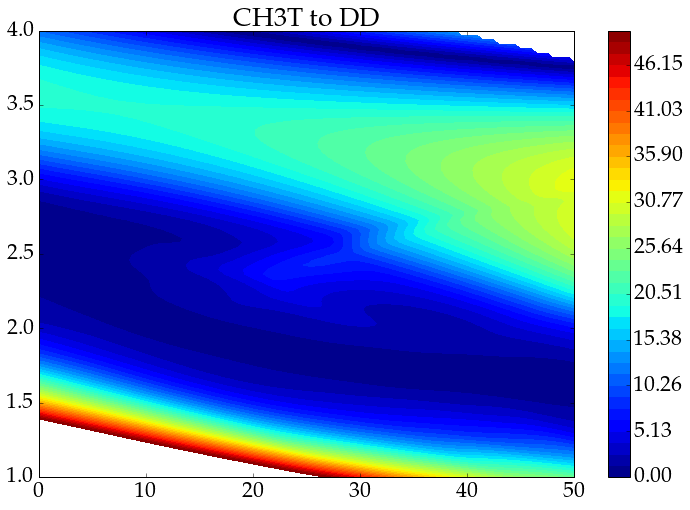

In [12]:
x_range_sel=[0, 50]
y_range_sel=[1.0,4.0]
pdf_WS, xWS, yWS, x_range, y_range= pdf_gen(df_all['s1area'], df_all['log10S2S1'],x_range_sel,y_range_sel)
pdf_T, xT, yT, x_range, y_range = pdf_gen(df_ch3t['s1area'],df_ch3t['log10S2S1'],x_range_sel,y_range_sel)
pdf_DD, xDD, yDD, x_range, y_range= pdf_gen(df_dd['s1area'], df_dd['log10S2S1'],x_range_sel,y_range_sel)
#xx=np.linspace(min(xr_WS+xr_DD+xr_T),max(xr_WS+xr_DD+xr_T),30) # adding the list and taking the min/max
#yy=np.linspace(min(yr_WS+yr_DD+yr_T),max(yr_WS+yr_DD+yr_T),30)
xx=x_range
yy=y_range

#print(xx,yy)
WS_DD=np.sum(pdf_WS*pdf_DD / np.sum(pdf_DD*pdf_DD))
WS_T=np.sum(pdf_WS*pdf_T / np.sum(pdf_T*pdf_T))
T_DD=np.sum(pdf_T*pdf_DD / np.sum(pdf_DD*pdf_DD))

######## add mpl figure. Contour plot of overlapping pdfs ################
#p_mat = plt.contour(xx,yy, np.sqrt(pdf_WS(xx,yy)*pdf_DD(xx,yy) / pdf_DD(xx,yy)*pdf_DD(xx,yy)),50 )
plt.title('WS to DD')
p_mat = plt.contourf(xx, yy, np.log10(pdf_DD)- np.log10(pdf_WS) ,levels=linspace(-20,7,20))
#self.matplot=mpl.to_bokeh(xkcd=False) # this will get current figure
colorbar()

figure()
#p_mat1 = plt.contour(xx,yy,np.sqrt(pdf_WS(xx,yy)*pdf_T(xx,yy) / pdf_T(xx,yy)*pdf_T(xx,yy)),50 )
p_mat1 = plt.contourf(xx, yy, np.log10(pdf_T) - np.log10(pdf_WS),levels=linspace(-10,2,20))
plt.title('WS to CH3T')
colorbar()
#self.matplot1=mpl.to_bokeh(xkcd=False) # this will get current figure

figure()
#p_mat2 = plt.contour(xx,yy,np.sqrt(pdf_T(xx,yy)*pdf_DD(xx,yy) / pdf_DD(xx,yy)*pdf_DD(xx,yy)),50 )
p_mat2 = plt.contourf(xx, yy, abs(np.log10(pdf_T)-log10(pdf_DD)) ,levels=linspace(0,50,40))
plt.title('CH3T to DD')
colorbar()
#self.matplot2=mpl.to_bokeh(xkcd=False) # this will get current figure

In [17]:
FM=np.log10(pdf_T)-np.log10(pdf_DD)
FM[isinf(FM)]=-200
FM[isnan(FM)]=-200
Z=scipy.interpolate.interp2d(xx,yy,FM,kind='linear')

In [66]:
def interpAD(Z,X,Y):
    vals=[]
    for x,y in zip (X,Y):
        vals.append(Z(x,y)[0])
    return np.array(vals)

In [67]:
interpAD(Z,xDD,yDD)

array([-2.12796283, -0.2115211 , -3.10089754, ..., -1.78288161,
       -2.99205794, -1.67572744])

<h1> Calculate signal to BG figure of merit </h1>

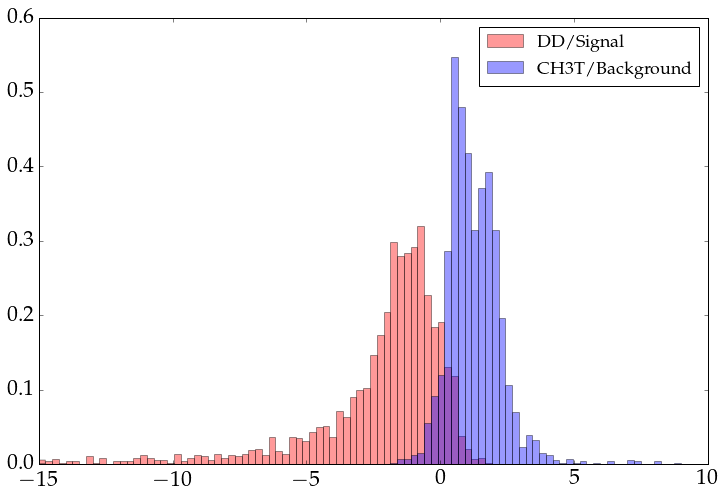

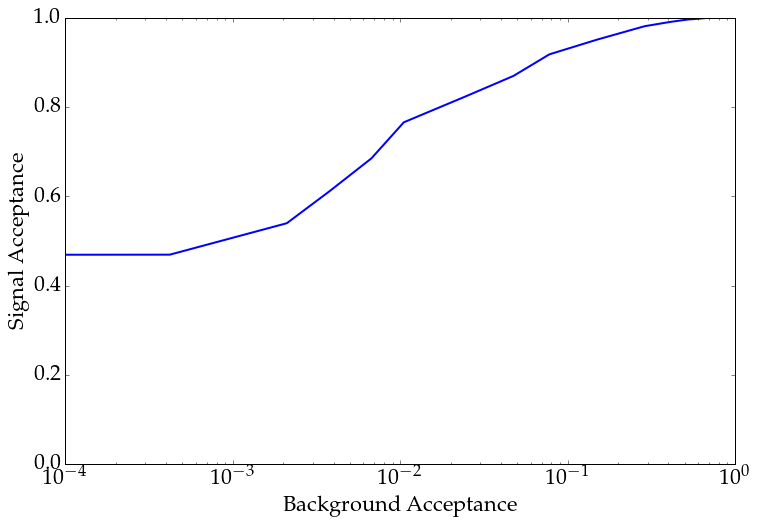

In [68]:
FM=np.log10(pdf_T)-np.log10(pdf_DD)
FM[isinf(FM)]=-200
FM[isnan(FM)]=-200
Z=scipy.interpolate.interp2d(xx,yy,FM,kind='linear')


nfmDD= hist(interpAD(Z,xDD,yDD),bins=linspace(-15,10,100),alpha=0.4,label='DD/Signal',color='r',normed=1)
nfmT= hist(interpAD(Z,xT,yT),bins=linspace(-15,10,100),alpha=0.4,label='CH3T/Background',color='b',normed=1)
xlim([-15,10])
legend(fontsize=18)

figure()
plot(cumsum(nfmT[0])/sum(nfmT[0]),cumsum(nfmDD[0])/sum(nfmDD[0]))
xlabel('Background Acceptance')
ylabel('Signal Acceptance')
xscale('log')

In [390]:
shape(xDD)

(2324,)

In [383]:
Z=scipy.interpolate.interp2d(xx,yy,FM,kind='linear')
Z(10,2.5)

array([ 1.7284813])

In [357]:
Z(10,2.5)

array([ nan])

In [280]:
a.sum()

1.0

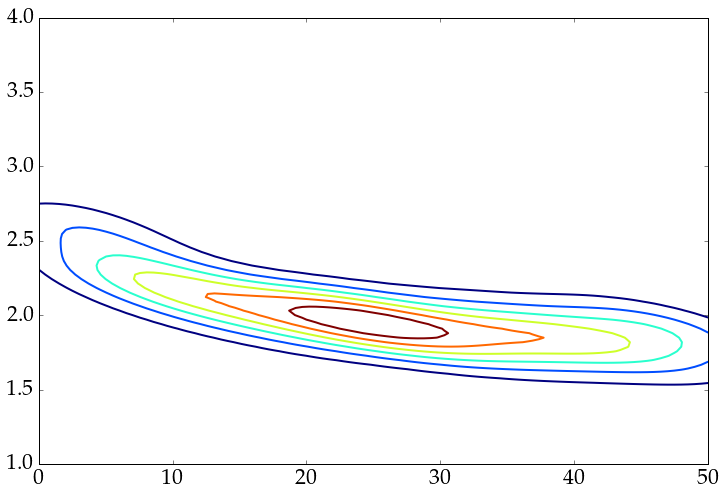

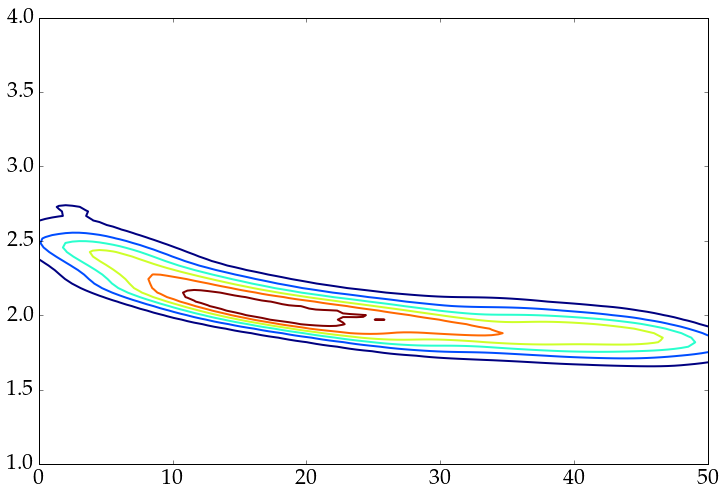

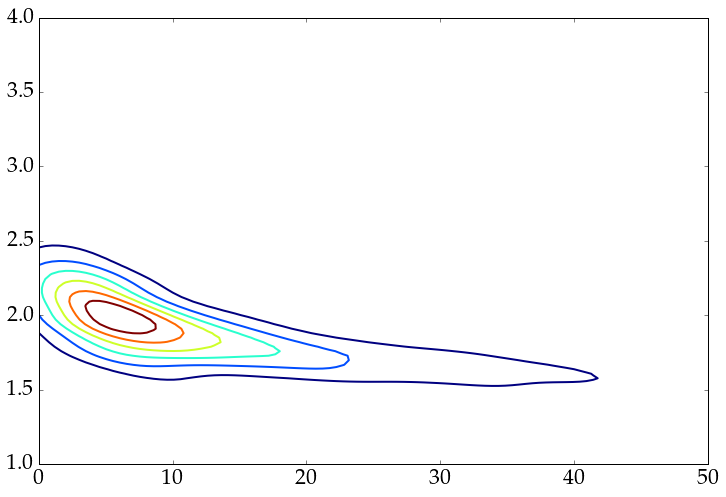

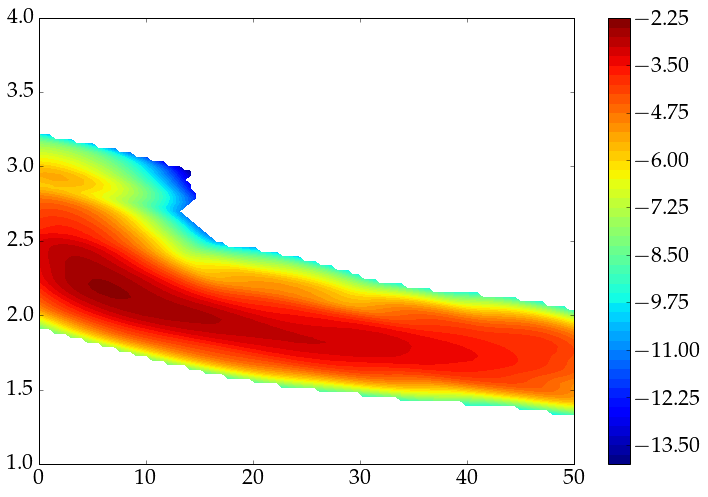

In [282]:
contour(x_range,y_range, pdf_WS)
figure()
contour(x_range,y_range, pdf_T)
figure()
contour(x_range,y_range, pdf_DD)
figure()
contourf(x_range,y_range, log10(a),50)
colorbar()

In [89]:
x_range_sel=[0, 50]
y_range_sel=[1.0,4.0]
pdf_WS,xr_WS,yr_WS,xedges_t,yedges_t= pdf_gen(df_all['s1area'], df_all['log10S2S1'],x_range_sel,y_range_sel)

In [147]:
pdf_T*pdf_DD/(pdf_T**2)

array([[  1.92343572e+114,   1.24597908e+113,   8.07314156e+111, ...,
          2.74781198e+026,   1.45367428e+026,   7.67031363e+025],
       [  3.84816399e+108,   2.59954757e+107,   1.75647433e+106, ...,
          7.43320316e+023,   4.07820780e+023,   2.23739913e+023],
       [  9.54727738e+102,   6.72578055e+101,   4.73922665e+100, ...,
          2.49176555e+021,   1.43409454e+021,   8.28483467e+020],
       ..., 
       [  5.71932740e+057,   2.85539535e+058,   1.42588470e+059, ...,
                      nan,               nan,               nan],
       [  1.59893463e+061,   8.32441161e+061,   4.33484184e+062, ...,
                      nan,               nan,               nan],
       [  5.54161468e+064,   3.00857410e+065,   1.63373635e+066, ...,
                      nan,               nan,               nan]])

In [114]:
r1

array([[  4.56423639e-06,   5.89319984e-06,   7.54546947e-06, ...,
          2.57530657e-04,   2.42132675e-04,   2.26288020e-04],
       [  1.21185707e-05,   1.51964514e-05,   1.88961117e-05, ...,
          2.31838099e-04,   2.14669255e-04,   1.97517544e-04],
       [  2.83689767e-05,   3.44070813e-05,   4.13849198e-05, ...,
          1.57079741e-04,   1.42316221e-04,   1.28085294e-04],
       ..., 
       [  3.93566325e-04,   3.90469773e-04,   3.84406929e-04, ...,
          4.32272035e-08,   2.90690553e-08,   1.93772833e-08],
       [  2.69224397e-04,   2.62607664e-04,   2.54089197e-04, ...,
          9.20517005e-09,   5.99917138e-09,   3.87498725e-09],
       [  1.37617759e-04,   1.31255296e-04,   1.24133588e-04, ...,
          1.21002477e-09,   7.62907118e-10,   4.76686342e-10]])

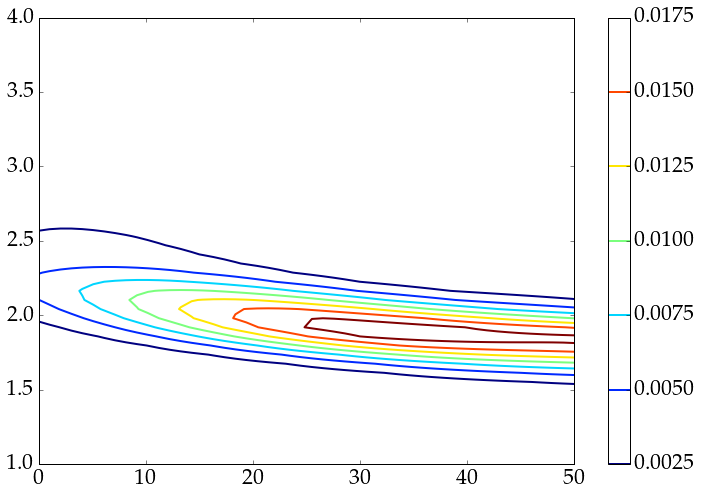

In [188]:
x_range=linspace(0,50,50)
y_range=linspace(1,4,50)
    
pdf_WS=scipy.stats.kde.gaussian_kde([df_all['s1area'], df_all['log10S2S1']])
q,w=np.meshgrid(x_range, y_range)
r1=pdf_WS([q.flatten(),w.flatten()])
r1.shape=(size(y_range),size(x_range))
contour(x_range,y_range, r1)
colorbar()

In [120]:
r1

array([[  4.56423639e-06,   5.89319984e-06,   7.54546947e-06, ...,
          2.57530657e-04,   2.42132675e-04,   2.26288020e-04],
       [  1.21185707e-05,   1.51964514e-05,   1.88961117e-05, ...,
          2.31838099e-04,   2.14669255e-04,   1.97517544e-04],
       [  2.83689767e-05,   3.44070813e-05,   4.13849198e-05, ...,
          1.57079741e-04,   1.42316221e-04,   1.28085294e-04],
       ..., 
       [  3.93566325e-04,   3.90469773e-04,   3.84406929e-04, ...,
          4.32272035e-08,   2.90690553e-08,   1.93772833e-08],
       [  2.69224397e-04,   2.62607664e-04,   2.54089197e-04, ...,
          9.20517005e-09,   5.99917138e-09,   3.87498725e-09],
       [  1.37617759e-04,   1.31255296e-04,   1.24133588e-04, ...,
          1.21002477e-09,   7.62907118e-10,   4.76686342e-10]])

In [64]:
r1=pdf_WS([q.flatten(),w.flatten()])



ValueError: points have dimension 2, dataset has dimension 1

In [ ]:
a

<h1> Calculate the overlap of the pdfs </h1>

In [ ]:
###### Make 1D discrimination variable ###################################
PDF_WS=pdf_WS(xx, yy)
PDF_T=pdf_T(xx, yy)
PDF_DD=pdf_DD(xx,yy)
cut_T=(~np.isnan(np.log(PDF_WS)-np.log(PDF_T))) & (np.isfinite(np.log(PDF_WS)-np.log(PDF_T)))
cut_DD=(~np.isnan(np.log(PDF_DD)-np.log(PDF_T))) & (np.isfinite(np.log(PDF_DD)-np.log(PDF_T)))
plt.figure()
histT=plt.hist(np.log(PDF_WS[cut_T])-np.log(PDF_T[cut_T]),bins=np.arange(-10,11,0.5),normed=True, cumulative=False,alpha=1, histtype='bar')
histDD=plt.hist(np.log(PDF_DD[cut_DD])-np.log(PDF_T[cut_DD]),bins=np.arange(-10,11,0.5),normed=True, cumulative=False,alpha=1, histtype='bar',color='red')
#renormalize after cuts, so that the sum of all remaining bins = 1
histT_n=histT[0]/sum(histT[0])
histDD_n=histDD[0]/sum(histDD[0])